## Imports / Helper Functions / Global Variables

In [1]:
# force geopandas to use shapely instead of pygeos
import os
os.environ['USE_PYGEOS'] = '0'

import numpy as np
import pandas as pd
import plotly.express as px
from shapely import wkt
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer
from shapely import get_coordinates, set_coordinates
from typing import List

In [2]:
# shorthand for datetime column

DATE_COL = 'Citation Issued DateTime'

In [25]:
# datetime manipulation helper functions

def filter_by_date_range(df: pd.DataFrame, column_name: str, start_string: str, end_string: str):
    return df[(df[column_name] >= pd.Timestamp(start_string)) & (df[column_name] <= pd.Timestamp(end_string))]

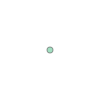

In [3]:
# helper functions for loading in US Census Bureau Geocoding data. This helps correct for ~10k observations with incorrect geolocation.

# 1ST -> 01ST, 2ND -> 02ND, etc., to be compatible
def inv_correct_numbered_streets(string):
    for i in range(1, 10):
        string = string.replace(f'{i}TH', f'0{i}TH')
    # 1st, 2nd and 3rd are special cases
    string = string.replace('1ST', '01ST')
    string = string.replace('2ND', '02ND')
    string = string.replace('3RD', '03RD')
    return string

def coord_string_to_point(coord_string):
    x, y = [float(string) for string in coord_string.split(',')]
    return Point(x, y)

coord_string_to_point("-122.46164710599999,37.77421091000008")

In [5]:
def load_geocoder_data(csv_path='../data/chinook_ct_correct.csv'):
    geo = pd.read_csv(csv_path, header=None)
    geo = geo[geo[2] == 'Match']
    geo[1] = geo[1].str.replace(', SAN FRANCISCO, CA,', '').apply(lambda x: x.strip())
    geo = geo[[1, 5]]
    geo.columns = ['street', 'geom']
    geo.street = geo.street.apply(inv_correct_numbered_streets)
    geo.geom = geo.geom.apply(coord_string_to_point)
    return geo

## Load Data and Fix Incorrect Data

In [7]:
geo_df = load_geocoder_data()
geo_df.head()

,street,geom
0,785 04TH AVE,POINT (-122.46164710599999 37.77421091000008)
1,756 08TH AVE,POINT (-122.46593421399996 37.77422294300004)
2,277 05TH AVE,POINT (-122.46339279499995 37.783491569000034)
3,404 08TH AVE,POINT (-122.46639889099998 37.78064289800005)
4,398 05TH ST,POINT (-122.40188964199996 37.77906450900008)


In [13]:
# create dictionary from pandas dataframe. 

geo_dict = pd.Series(geo_df.geom.values,index=geo_df.street).to_dict()

In [10]:
geo_df.shape

(2500, 2)

In [19]:
df = pd.read_csv("../data/data_2022_with_geom.csv")
df.head()

,Citation Number,Citation Issued DateTime,Violation,Violation Description,Citation Location,Vehicle Plate State,Vehicle Plate,Fine Amount,Date Added,geom
0,950226616,04/20/2022 12:10:00 PM,TRC7.2.22,STR CLEAN,1318 FILBERT ST,CA,V507699,84.0,05/01/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
1,952126114,06/17/2022 04:12:00 PM,TRC7.2.20,RES/OT,1318 FILBERT ST,CA,BV44D97,96.0,07/17/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
2,950441903,04/23/2022 03:13:00 PM,V5200,NO PLATES,1318 FILBERT ST,CA,V507699,121.0,05/18/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
3,948460144,02/22/2022 11:54:00 AM,TRC7.2.20,RES/OT,1318 FILBERT ST,TX,HVT6737,96.0,05/23/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
4,948169644,02/17/2022 01:39:00 PM,TRC7.2.20,RES/OT,1318 FILBERT ST,OH,HQA6554,96.0,04/03/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)


In [20]:
df['geom'] = df.geom.apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geom')
df.crs = 'EPSG:4326'

In [21]:
# TODO: rewrite this using np.where or pandas where 
# TODO: use a better geocoder to fix more rows.

def fix_geom(row):
    if row['Citation Location'] in geo_dict:
        return geo_dict[row['Citation Location']]
    return row['geom']

df['geom'] = df.apply(fix_geom, axis=1)

## Add / Modify Dataframe Columns

In [22]:
df[DATE_COL] = pd.to_datetime(df[DATE_COL])

In [23]:
# add auxillary date attribute columns based on the datetime. 

df['citation_day'] = df[DATE_COL].dt.day_name()
df['citation_hour'] = df[DATE_COL].dt.hour
df['citation_date'] = df[DATE_COL].dt.date

In [24]:
has_location_string = df[~df['Citation Location'].isnull()]

## Spatial Join

In [26]:
# load dataframe of street segments

street_df = pd.read_csv('../data/street_sweeping.csv')
street_df = street_df[~street_df.Line.isnull()]
street_df.loc[:, 'Line'] = street_df.Line.apply(wkt.loads)
street_df = gpd.GeoDataFrame(street_df, geometry='Line')
street_df.crs = 'EPSG:4326'

In [29]:
# TODO: technically should project into a flat geometry in order to get more accurate distances  

unique_streets = street_df.drop_duplicates(subset='Line')
unique_streets = unique_streets[['Corridor', 'Limits', 'Line']]

# save copy of geom column because it will be destroyed by projection / join.
unique_streets['street_geom_3d'] = unique_streets['Line']
unique_streets['street_length'] = unique_streets.street_geom_3d.apply(lambda x: x.length)

In [39]:
joined = gpd.sjoin_nearest(df, unique_streets, distance_col='dist', how='left')
joined.shape

/Users/bryanwang/opt/miniconda3/envs/stat-222/lib/python3.9/site-packages/geopandas/array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


(1063988, 19)

## Group and Cluster

In [44]:
joined['street_id'] = joined['Corridor'] + ' ' + joined['Limits']

In [48]:
joined.set_index(['citation_date', 'street_id'])

Citation Number  \
citation_date street_id                                             
2022-04-20    Polk St Union St  -  Filbert St           950226616   
2022-06-17    Polk St Union St  -  Filbert St           952126114   
2022-04-23    Polk St Union St  -  Filbert St           950441903   
2022-02-22    Polk St Union St  -  Filbert St           948460144   
2022-02-17    Polk St Union St  -  Filbert St           948169644   
...                                                           ...   
2022-11-08    11th Ave Lake St  -  California St        957011624   
              37th Ave Vicente St  -  Wawona St         957032602   
              28th Ave Taraval St  -  Ulloa St          957032462   
              Anza St 35th Ave  -  36th Ave             957009874   
              Sacramento St Drumm St  -  Davis St       957035424   

                                                  Citation Issued DateTime  \
citation_date street_id                                                      
2022-04-20    Polk St Union St  -  Filbert St          2022-04-20 12:10:00   
2022-06-17    Polk St Union St  -  Filbert St          2022-06-17 16:12:00   
2022-04-23    Polk St Union St  -  Filbert St          2022-04-23 15:13:00   
2022-02-22    Polk St Union St  -  Filbert St          2022-02-22 11:54:00   
2022-02-17    Polk St Union St  -  Filbert St          2022-02-17 13:39:00   
...                                                                    ...   
2022-11-08    11th Ave Lake St  -  California St       2022-11-08 09:27:00   
              37th Ave Vicente St  -  Wawona St        2022-11-08 09:51:00   
              28th Ave Taraval St  -  Ulloa St         2022-11-08 09:05:00   
              Anza St 35th Ave  -  36th Ave            2022-11-08 12:04:00   
              Sacramento St Drumm St  -  Davis St      2022-11-08 12:24:00   

                                                   Violation  \
citation_date street_id                                        
2022-04-20    Polk St Union St  -  Filbert St      TRC7.2.22   
2022-06-17    Polk St Union St  -  Filbert St      TRC7.2.20   
2022-04-23    Polk St Union St  -  Filbert St          V5200   
2022-02-22    Polk St Union St  -  Filbert St      TRC7.2.20   
2022-02-17    Polk St Union St  -  Filbert St      TRC7.2.20   
...                                                      ...   
2022-11-08    11th Ave Lake St  -  California St   TRC7.2.22   
              37th Ave Vicente St  -  Wawona St    TRC7.2.22   
              28th Ave Taraval St  -  Ulloa St     TRC7.2.22   
              Anza St 35th Ave  -  36th Ave        TRC7.2.22   
              Sacramento St Drumm St  -  Davis St  TRC7.2.25   

                                                  Violation Description  \
citation_date street_id                                                   
2022-04-20    Polk St Union St  -  Filbert St                 STR CLEAN   
2022-06-17    Polk St Union St  -  Filbert St                    RES/OT   
2022-04-23    Polk St Union St  -  Filbert St                 NO PLATES   
2022-02-22    Polk St Union St  -  Filbert St                    RES/OT   
2022-02-17    Polk St Union St  -  Filbert St                    RES/OT   
...                                                                 ...   
2022-11-08    11th Ave Lake St  -  California St              STR CLEAN   
              37th Ave Vicente St  -  Wawona St               STR CLEAN   
              28th Ave Taraval St  -  Ulloa St                STR CLEAN   
              Anza St 35th Ave  -  36th Ave                   STR CLEAN   
              Sacramento St Drumm St  -  Davis St              RED ZONE   

                                                  Citation Location  \
citation_date street_id                                               
2022-04-20    Polk St Union St  -  Filbert St       1318 FILBERT ST   
2022-06-17    Polk St Union St  -  Filbert St       1318 FILBERT ST   
2022-04-23    Polk St Union St  -  Filbert S

In [42]:
unique_streets[unique_streets.street_length > 0.01]

,Corridor,Limits,Line,street_geom_3d,street_length
215,Great Hwy,Lincoln Way - Sloat Blvd,"LINESTRING (-122.51034 37.76400, -122.51025 37...","LINESTRING (-122.51034 37.76400, -122.51025 37...",0.028796
377,Great Hwy,Lincoln Way - Sloat Blvd,"LINESTRING (-122.51034 37.76400, -122.51041 37...","LINESTRING (-122.51034 37.76400, -122.51041 37...",0.028797
607,Great Hwy,Sloat Blvd - Skyline Blvd,"LINESTRING (-122.50672 37.73547, -122.50666 37...","LINESTRING (-122.50672 37.73547, -122.50666 37...",0.012101
2474,Great Hwy,Sloat Blvd - Skyline Blvd,"LINESTRING (-122.50672 37.73547, -122.50682 37...","LINESTRING (-122.50672 37.73547, -122.50682 37...",0.012255
3218,John Muir Dr,Lake Merced Blvd - Skyline Blvd,"LINESTRING (-122.48572 37.70809, -122.48626 37...","LINESTRING (-122.48572 37.70809, -122.48626 37...",0.018843
14682,John F Shelley Dr,Cambridge St - Mansell St,"LINESTRING (-122.41648 37.72181, -122.41668 37...","LINESTRING (-122.41648 37.72181, -122.41668 37...",0.016105


In [40]:
# TODO: figure out how to resolve points that get mapped to multiple streets. for now, seems like only a small number have this problem so we ignore it.

has_multiple_citations = joined['Citation Number'].value_counts()
joined = joined[joined['Citation Number'].isin(has_multiple_citations[has_multiple_citations == 1].index)]


In [41]:
joined.shape

(1055954, 19)